# Clustering Crypto

In [1]:
#Optional: Upload and deploy the Jupyter notebook using Amazon SageMaker.
!pip install -U altair

     |████████████████████████████████| 727 kB 4.9 MB/s            


In [5]:
# Initial imports
import altair as alt #For AWS Sagemaker
import requests
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
import scipy
#import xarray
import seaborn as sns
#import panel as pn
#pn.extension('plotly')
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
#from pandas_profiling import ProfileReport
#import sweetviz
#import dtale
%matplotlib inline

import plotly.express as px
import datetime as dt

### Fetching Cryptocurrency Data

In [2]:
# Use the following endpoint to fetch json data
#url = "https://min-api.cryptocompare.com/data/all/coinlist"
#url_data = requests.get(url)
#url_data.json()['Data']
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.
#crypto_df=pd.DataFrame.from_dict(url_data.json()['Data'], orient='index')
#crypto_df.head()
#crypto_df.columns

#Since the url output does not contain TotalCoinSupply column, I will be reverting to the supplied csv file for further
#analysis

In [6]:
# Alternatively, use the provided csv file:
file_path = Path("./Data/crypto_data.csv")

# Create a DataFrame
crypto_df=pd.read_csv(file_path)
crypto_df.head()

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


### Data Preprocessing

In [7]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
crypto_df_c=crypto_df[[ 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply']].copy()
crypto_df_c.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [8]:
#Data Type Check
crypto_df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CoinName         1252 non-null   object 
 1   Algorithm        1252 non-null   object 
 2   IsTrading        1252 non-null   bool   
 3   ProofType        1252 non-null   object 
 4   TotalCoinsMined  744 non-null    float64
 5   TotalCoinSupply  1252 non-null   object 
dtypes: bool(1), float64(1), object(4)
memory usage: 50.3+ KB


In [9]:
# Keep only cryptocurrencies that are trading
crypto_df_t=crypto_df_c[crypto_df_c['IsTrading']==True]


In [10]:
#Convert non Text/boolean columns to float -
# Convert Data type for TotalCoinSupply  to Float

crypto_df_t["TotalCoinSupply"] = crypto_df_t['TotalCoinSupply'].str.replace(' ', '') 
crypto_df_t["TotalCoinSupply"] = crypto_df_t['TotalCoinSupply'].str.replace(',', '')
crypto_df_t["TotalCoinSupply"] = crypto_df_t['TotalCoinSupply'].astype(float)

In [11]:
# Keep only cryptocurrencies with a working algorithm
crypto_df_t['Algorithm'].unique()
# Each entry seems to have a valid Algorithm

array(['Scrypt', 'X11', 'SHA-256', 'X13', 'Ethash', 'CryptoNight-V7',
       'Equihash', 'SHA-512', 'Multiple', 'X15', 'NIST5', 'Quark',
       'Groestl', 'PoS', 'NeoScrypt', 'SHA3', 'HybridScryptHash256',
       'Scrypt-n', 'PHI1612', 'Lyra2REv2', 'CryptoNight', 'Shabal256',
       'Counterparty', 'Blake', 'Momentum', 'Stanford Folding', 'QuBit',
       'XG Hash', 'M7 POW', 'Curve25519', 'Lyra2RE', 'QUAIT', 'vDPOS',
       'Blake2b', 'BLAKE256', '1GB AES Pattern Search', 'Dagger',
       'CryptoNight-Lite', 'X11GOST', 'SHA-256D', 'POS 3.0',
       'Progressive-n', 'DPoS', 'Lyra2Z', 'X14', 'Time Travel', 'Argon2',
       'Keccak', 'Blake2S', 'Dagger-Hashimoto', '536', 'Argon2d',
       'Cloverhash', 'Skein', 'SkunkHash v2 Raptor',
       'VeChainThor Authority', 'Ouroboros', 'POS 2.0', 'SkunkHash',
       'C11', 'Proof-of-BibleHash', 'SHA-256 + Hive',
       'Proof-of-Authority', 'XEVAN', 'VBFT', 'YescryptR16', 'IMesh',
       'Green Protocol', 'Semux BFT consensus', 'X16R', 'Tribus',


In [12]:
# Remove the "IsTrading" column
crypto_df_t.drop(columns='IsTrading',inplace=True)

In [13]:
# Remove rows with at least 1 null value
display(crypto_df_t.isnull().sum())
crypto_df_n=crypto_df_t.dropna(how='any',axis=0)
display(crypto_df_n.isnull().sum())
display(crypto_df_n.shape)

CoinName             0
Algorithm            0
ProofType            0
TotalCoinsMined    459
TotalCoinSupply      0
dtype: int64

CoinName           0
Algorithm          0
ProofType          0
TotalCoinsMined    0
TotalCoinSupply    0
dtype: int64

(685, 5)

In [14]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df_m=crypto_df_n[crypto_df_n['TotalCoinsMined'] > 0]

In [15]:
# Drop rows where there are 'N/A' text values
#crypto_df_m=="N/A"
#np.isin(crypto_df_m, ['N/A']).sum()

crypto_df_na=crypto_df_m[~crypto_df_m.isin(['N/A']).any(axis=1)]



In [16]:
crypto_df_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532 entries, 0 to 1247
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CoinName         532 non-null    object 
 1   Algorithm        532 non-null    object 
 2   ProofType        532 non-null    object 
 3   TotalCoinsMined  532 non-null    float64
 4   TotalCoinSupply  532 non-null    float64
dtypes: float64(2), object(3)
memory usage: 24.9+ KB


In [17]:
#Let's check correlation between the features
correlation = crypto_df_na.corr()
correlation.style.background_gradient(cmap='coolwarm')

,TotalCoinsMined,TotalCoinSupply
TotalCoinsMined,1.000000,0.702301
TotalCoinSupply,0.702301,1.000000


In [18]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
# We do this as we do not want it to be part of the feature
crypto_df_coinname=crypto_df_na[['CoinName']].copy()
crypto_df_coinname.head()

,CoinName
0,42 Coin
2,404Coin
5,EliteCoin
7,Bitcoin
8,Ethereum


In [19]:
#Check for any nulls
crypto_df_coinname.isnull().sum()

CoinName    0
dtype: int64

In [20]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df_na.drop(columns='CoinName',inplace=True)

In [21]:
#Make a copy of the dataframe to be used later 
crypto_df_no=crypto_df_na.copy()

In [22]:
# Create dummy variables for text features
# we will take an help of preprocessing module from sklearn package and them import LabelEncoder

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

categorical_columns = crypto_df_na.select_dtypes(["object"]).columns
for column in categorical_columns:
    crypto_df_na[column]=labelencoder.fit_transform(crypto_df_na[column])
    

In [23]:
# Standardize data
#TotalCoinsMined and TotalCoinSupply value has higher order magnitudes then other features and if we do not scale then
# PCA will give more weightage to these features.

scale=StandardScaler()
crypto_df_s = scale.fit_transform(crypto_df_na)
#crypto_df_s = pd.DataFrame(crypto_df_s, columns=crypto_df_na.columns)

### Reducing Dimensions Using PCA

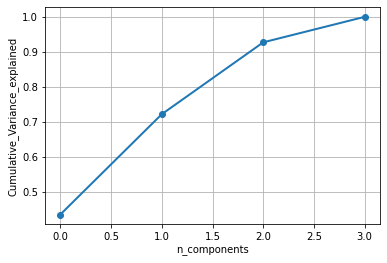

In [24]:
#Let's check what is the ideal dimension
pca=PCA()
pca.fit_transform(crypto_df_s)
cum_var_explained=np.cumsum(pca.explained_variance_ratio_)
#plot PCA spectrum   
plt.figure(1,figsize=(6,4))
plt.clf()  
plt.plot(cum_var_explained,linewidth=2,marker='o')  
plt.axis('tight')  
plt.grid() 
plt.xlabel('n_components') 
plt.ylabel('Cumulative_Variance_explained')  
plt.show()

In [25]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)
crypto_df_pca = pca.fit_transform(crypto_df_s)

# Calculate the PCA explained variance ratio
pca.explained_variance_ratio_

array([0.43504669, 0.28670411, 0.20538956])

In [27]:
# Create a DataFrame with the principal components data
crypto_df_pca=pd.DataFrame(

    crypto_df_pca,
    columns = ["PCA1","PCA2","PCA3"],index=crypto_df_na.index
)
# Review the PCA DataFrame
# YOUR CODE HERE)
crypto_df_pca.head()

,PCA1,PCA2,PCA3
0,-0.417875,0.810296,0.372138
2,-0.396564,0.815135,0.373256
5,3.124073,2.209780,0.504335
7,-0.192083,0.016266,-0.072910
8,-0.044116,-1.167492,1.012525


([<matplotlib.axis.XTick at 0x7f060fb79588>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

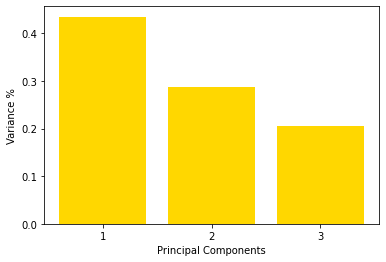

In [28]:
# Plotting the variances for each PC
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='gold')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)



### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [30]:
# Calculate the inertia for the range of k values

inertia = []
k = list(range(1, 11))
# Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the spread_df DataFrame
# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1)
    k_model.fit(crypto_df_pca)
    inertia.append(k_model.inertia_)



# Create the Elbow Curve using Altair
elbow_data = {"k": k, "inertia": inertia}

df_elbow = pd.DataFrame(elbow_data)
alt.Chart(df_elbow,title="Elbow Curve").mark_line().encode(
    x="k", 
    y="inertia" 
     
    
)


alt.Chart(...)

Running K-Means with `k=4`

In [31]:
# Initialize the K-Means model
kmeans = KMeans(n_clusters=4,random_state=1)
# Fit the model
kmeans.fit(crypto_df_pca)
# Predict clusters
k_predict =  kmeans.predict(crypto_df_pca)
# Create a new DataFrame including predicted clusters and cryptocurrencies features

crypto_df_predictions = crypto_df_no.join(crypto_df_pca)
crypto_df_predictions['CoinName'] = crypto_df_coinname['CoinName']
crypto_df_predictions['clusters_predicted'] = k_predict

crypto_df_predictions.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PCA1,PCA2,PCA3,CoinName,clusters_predicted
0,Scrypt,PoW/PoS,4.199995e+01,4.200000e+01,-0.417875,0.810296,0.372138,42 Coin,1
2,Scrypt,PoW/PoS,1.055185e+09,5.320000e+08,-0.396564,0.815135,0.373256,404Coin,1
5,X13,PoW/PoS,2.927942e+10,3.141590e+11,3.124073,2.209780,0.504335,EliteCoin,1
7,SHA-256,PoW,1.792718e+07,2.100000e+07,-0.192083,0.016266,-0.072910,Bitcoin,1
8,Ethash,PoW,1.076842e+08,0.000000e+00,-0.044116,-1.167492,1.012525,Ethereum,0


In [46]:
crypto_df_predictions['TotalCoinsMined'] = crypto_df_predictions['TotalCoinsMined'].astype(float) / 1000000
crypto_df_predictions['TotalCoinSupply'] = crypto_df_predictions['TotalCoinSupply'].astype(float) / 1000000

### Visualizing Results

#### Scatter Plot with Tradable Cryptocurrencies

In [47]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"


alt.Chart(crypto_df_predictions).mark_point(size=60).encode(
    alt.X('TotalCoinsMined',
        scale=alt.Scale(zero=False)
    ),
   
   alt.Y('TotalCoinSupply',
        scale=alt.Scale(zero=False)
    ),
   color="clusters_predicted",
   tooltip="CoinName",
   shape="CoinName"
).interactive()

alt.Chart(...)

In [48]:
#Visualize all the principal components
from sklearn.decomposition import PCA



labels=["PCA1","PCA2","PCA3"]
fig = px.scatter_matrix(
    pca.fit_transform(crypto_df_s),
    labels=labels,
    color=crypto_df_predictions["clusters_predicted"]
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [49]:
#Use the altair scatter plot to visualize the clusters. Since this is a 2D-Scatter, use x="PC 1" and y="PC 2" for the axes, 
#and add the following columns as tool tips: "CoinName", "Algorithm", "TotalCoinsMined", "TotalCoinSupply".

alt.Chart(crypto_df_predictions).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative', scale=alt.Scale(zero=False)),
    alt.Y(alt.repeat("row"), type='quantitative', scale=alt.Scale(zero=False)),
     color="clusters_predicted",
    tooltip=['Algorithm','TotalCoinsMined','TotalCoinSupply','CoinName']
).properties(
    width=150,
    height=150,
).repeat(
    row=["PCA1","PCA2","PCA3"],
    column=["PCA1","PCA2","PCA3"]
).properties(
    title="ScatterMatrix of 'PCA1','PCA2','PCA3'"
).interactive()

alt.RepeatChart(...)

#### Table of Tradable Cryptocurrencies

In [50]:
#Show the table of current tradable cryptocurrencies using the display() command.


display(crypto_df_predictions[['Algorithm','ProofType','TotalCoinsMined','TotalCoinSupply','CoinName','clusters_predicted']])

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,CoinName,clusters_predicted
0,Scrypt,PoW/PoS,0.000042,0.000042,42 Coin,1
2,Scrypt,PoW/PoS,1055.184902,532.000000,404Coin,1
5,X13,PoW/PoS,29279.424623,314159.000000,EliteCoin,1
7,SHA-256,PoW,17.927175,21.000000,Bitcoin,1
8,Ethash,PoW,107.684223,0.000000,Ethereum,0
...,...,...,...,...,...,...
1238,SHA-256,DPoS,1999.999995,2000.000000,ZEPHYR,3
1242,Scrypt,PoW/PoS,14.931046,250.000000,Gapcoin,1
1245,CryptoNight,PoW,980.222595,1400.222610,Beldex,0
1246,Equihash,PoW,7.296538,21.000000,Horizen,0


In [51]:
# Print the total number of tradable cryptocurrencies
print(f"Total number of tradable cryptocurrencies: {crypto_df_predictions['CoinName'].nunique()}")

Total number of tradable cryptocurrencies: 531
